In [1]:
#importing the libraries 
from collections import Counter
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from numpy import array
import pandas as pd
import numpy as np
import preprocessor as p
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


In [2]:
#Reading the data
data = pd.read_csv('train.txt', sep='\t')

# Understanding the contents of the tweets 

In [3]:
data.head()

,Tweet index,Label,Tweet text
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...


In [4]:
np.unique(data['Label'])

array([0, 1], dtype=int64)

In [5]:
data.groupby('Label').count()

,Tweet index,Tweet text
Label,,
0,1916,1916
1,1901,1901


In [6]:
#cleaning the tweets 
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.SMILEY)
cleaned_text = []
for i in data['Tweet text']:
    cleaned_text.append(p.clean(i))

In [7]:
#getting all the words 
all_words = []
for i in cleaned_text:
    all_words = all_words + i.split()

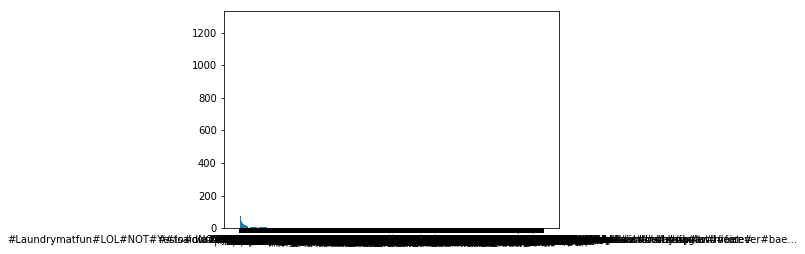

In [8]:
#getting the word counts 
counts = Counter(all_words)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.show()

In [9]:
#getting the 10 most common words 
counts.most_common(10)

[('the', 1272),
 ('to', 1198),
 ('a', 979),
 ('I', 929),
 ('#not', 742),
 ('is', 619),
 ('#sarcasm', 613),
 ('and', 610),
 ('in', 572),
 ('of', 571)]

# Pre-Processing steps

In [10]:
#Seperating into irony and non irony 
irony = []
non_irony = []

for i in range(len(data)):
    if data['Label'][i] == 1:
        irony.append(data['Tweet text'][i])
    else:
        non_irony.append(data['Tweet text'][i])

In [11]:
#seperating into test and training 
irony_train = irony[:-382]
irony_test = irony[-382:]
non_irony_train = non_irony[:-382]
non_irony_test = non_irony[-382:]

In [12]:
#creation of test and training 
Xtrain = irony_train + non_irony_train
Xtest = irony_test + non_irony_test

In [13]:
#creating test and training labels 
ytrain = array([1 for _ in range(1519)] + [0 for _ in range(1534)])
ytest = array([1 for _ in range(382)] + [0 for _ in range(382)])

In [14]:
#function to clean the tweets 
def clean_docs(tweet_list):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')) 
    p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.SMILEY)
    cleaned_text = []
    for i in tweet_list:
        cleaned_text.append(p.clean(i))
        
    stop_word_cleared = []  
    for j in cleaned_text:
        word_tokens = j.split()
        filtered_sentence = ''

        for w in word_tokens: 
            if w not in stop_words: 
                w = lemmatizer.lemmatize(w)
                filtered_sentence = filtered_sentence + ' ' +w.lower()
        stop_word_cleared.append(filtered_sentence)
    return stop_word_cleared

In [15]:
Xtrain_cleaned = clean_docs(Xtrain)
Xtest_cleaned = clean_docs(Xtest)

In [16]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(Xtrain_cleaned)

In [17]:
#Function to do encoding 
def encoding(encoding_list,max_length):
    encoded_docs = tokenizer.texts_to_sequences(encoding_list)
    encoded_list = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return encoded_list

In [18]:
# pad sequences
max_length = max([len(s.split()) for s in Xtrain_cleaned])
Xtrain_padded = encoding(Xtrain_cleaned,max_length)

In [19]:
vocab_size = len(tokenizer.word_index) + 1

# Building the model 

In [20]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain_padded, ytrain, epochs=10, verbose=2)

Epoch 1/10
 - 54s - loss: 0.6780 - acc: 0.6083
Epoch 2/10
 - 51s - loss: 0.2843 - acc: 0.9004
Epoch 3/10
 - 51s - loss: 0.0888 - acc: 0.9689
Epoch 4/10
 - 51s - loss: 0.0333 - acc: 0.9905
Epoch 5/10
 - 51s - loss: 0.0136 - acc: 0.9964
Epoch 6/10
 - 51s - loss: 0.0070 - acc: 0.9984
Epoch 7/10
 - 52s - loss: 0.0034 - acc: 0.9993
Epoch 8/10
 - 50s - loss: 0.0019 - acc: 1.0000
Epoch 9/10
 - 51s - loss: 0.0012 - acc: 1.0000
Epoch 10/10
 - 52s - loss: 0.0010 - acc: 1.0000


In [22]:
Xtest_padded = encoding(Xtest_cleaned,max_length)

In [23]:
loss, acc = model.evaluate(Xtest_padded, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 85.471204


# Getting the predictions 

In [24]:
#Reading the test data
test_data = pd.read_csv('test.csv')

In [25]:
test_data.head()

,Index,Text
0,1,@Callisto1947 Can U Help?||More conservatives ...
1,2,"Just walked in to #Starbucks and asked for a ""..."
2,3,#NOT GONNA WIN http://t.co/Mc9ebqjAqj
3,4,@mickymantell He is exactly that sort of perso...
4,5,So much #sarcasm at work mate 10/10 #boring 10...


In [26]:
#Cleaning the test data
testset_cleaned = clean_docs(test_data['Text'])

In [27]:
testset_cleaned[:5]

[' can u help?||more conservative needed #tsu + get paid 4 posting stuff like this!||you $ go',
 ' just walked #starbucks asked "tall blonde" hahahaha #irony',
 ' #not gonna win',
 ' he exactly sort person. weirdo!',
 " so much #sarcasm work mate 10/10 #boring 100% #dead mate full #shit absolutely #sleeping mate can't handle #sarcasm"]

In [28]:
#Encoding the test data
testset_cleaned_padded = encoding(testset_cleaned,max_length)

In [29]:
#Getting the predictions 
predicted = []
for i in testset_cleaned_padded:
    reshaped = i.reshape(1,125)
    pred = model.predict_classes(reshaped)
    predicted.append(pred[0][0])

In [30]:
#writing the csv 
prediction = pd.DataFrame(predicted, columns=['Label']).to_csv('submission1.csv')